# Word Vectors

Word vectors are vectors of real numbers where each data point captures a dimension of  the **word's meaning**.  
The word vectors can be used as features in many natural language processing and machine learning applications.  
## Interesting properties
Word vectors are able to capture many linguistic regularities and semantically similar words have similar vectors.  
A simple way to investigate the learned representations is to find the closest words for a user-specified word. The distance tool serves that purpose. For example, if you enter 'france', distance will display the most similar words and their distances to 'france', , such as other countries.  
Once the words are mapped into numerical vectors, you can  apply algebraic operations to them, for example vector operations:  
vector('Paris') - vector('France') + vector('Italy') results in a vector that is very close to vector('Rome').  
Similarly vector('king') - vector('man') + vector('woman') is close to vector('queen').

Many methods exist to map this mathematical embedding into a vector space with lower dimension. One of them is [Google's word2vec](https://code.google.com/archive/p/word2vec/):  
The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. 

To observe strong regularities in the word vector space, it is needed to train the models on large data set, with sufficient vector dimensionality.   
Using the word2vec tool, it is possible to train models on huge data sets (up to hundreds of billions of words).
We are publishing pre-trained vectors trained on part of Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.

Note that because the original google news word embedding dataset is about 3.64 gigabytes,
the workspace is not able to handle the full file set.  So I have downloaded the full dataset,
extracted a sample of the words that we're going to analyse and saved
it in a pickle file called `word_embeddings_capitals.p`

## Read the data

In [1]:
import pandas as pd # to read the dataset

In [2]:
data = pd.read_csv('../datasets/capitals.txt', delimiter=' ')
data.columns = ['city1', 'country1', 'city2', 'country2']

# print first and last five elements in the DataFrame
data.head()

,city1,country1,city2,country2
0,Athens,Greece,Bangkok,Thailand
1,Athens,Greece,Beijing,China
2,Athens,Greece,Berlin,Germany
3,Athens,Greece,Bern,Switzerland
4,Athens,Greece,Cairo,Egypt


In [3]:
data.tail()

,city1,country1,city2,country2
4946,Zagreb,Croatia,Dakar,Senegal
4947,Zagreb,Croatia,Damascus,Syria
4948,Zagreb,Croatia,Dhaka,Bangladesh
4949,Zagreb,Croatia,Doha,Qatar
4950,Zagreb,Croatia,Dublin,Ireland


In [4]:
data.describe()

,city1,country1,city2,country2
count,4951,4951,4951,4951
unique,115,115,115,115
top,Helsinki,Egypt,Madrid,France
freq,61,61,61,61


Now we will load the word embeddings as a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries).
As stated, these have already been obtained through a machine learning algorithm. 
It's a pre-trained subset of the huge Google News dataset (see Introduction).

In [5]:
import pickle  # object serializer: convert byte stream into a Python object

In [6]:
word_embeddings = pickle.load(open("../datasets/word_embeddings_subset.p", "rb"))

Now that the model is loaded, we can take a look at the word representations. First, note that the _word_embeddings_ is a dictionary. Each word is the key to the entry, and the value is its corresponding vector presentation. Remember that square brackets allow access to any entry if the key exists. 

In [7]:
print("dimension: ", word_embeddings['Spain'].shape[0])

dimension:  300


Each of the word embedding is a 300-dimensional vector.

In [8]:
countryVector = word_embeddings['country'] # Get the vector representation for the word 'country'
print(type(countryVector)) # Print the type of the vector. Note it is a numpy array
print(countryVector[0:10]) # Print the first ten values of the vector.  

<class 'numpy.ndarray'>
[-0.08007812  0.13378906  0.14355469  0.09472656 -0.04736328 -0.02355957
 -0.00854492 -0.18652344  0.04589844 -0.08154297]


It is important to note that we store each vector as a NumPy array. It allows us to use the linear algebra operations on it. 

## How to visualise the word vectors
Word embeddings are multidimensional arrays, usually with hundreds of attributes that pose a challenge for its interpretation.  
One way is to plot charts that will allow us to illustrate the mechanical part in Python.
Plotting the dots gives an idea of the words, the arrow representations help to visualise the vector's alignment as well.

In [9]:
import numpy as np

In [10]:
# Helper: Get the vector representation for a given word
def getVector(w):
    return word_embeddings[w]

### Plotting the vectors using PCA
Now we will explore plotting the vectors and the distance between word vectors after reducing their dimension, using the principal component analysis (PCA) technique that we have already seen. As we noticed, we are working in a 300-dimensional space in this case. Although from a computational perspective we will be able to perform a good job, it is impossible to visualise results in such high dimensional spaces.  
PCA is a method that projects our vectors in a space of reduced dimension, while keeping the maximum information about the original vectors in their reduced counterparts. In this case, by maximum infomation we mean that the Euclidean distance between the original vectors and their projected siblings is minimal. Hence vectors that were originally close in the embeddings dictionary, will produce lower dimensional vectors that are still close to each other.
When you map out the words, similar words will be clustered next to each other. For example, the words 'sad', 'happy', 'joyful' all describe emotion and are supposed to be near each other when plotted. The words: 'oil', 'gas', and 'petroleum' all describe natural resources. Words like 'city', 'village', 'town' could be seen as synonyms and describe a similar thing.  
  
Before plotting the words, we need to first reduce each word vector with PCA into 2 dimensions and compute the eigenvectors and the eigenvalues of the covariance matrix.
  
We start by defining two helper functions:

In [11]:
def computePCA(X, n_components=2):
    """
    Input:
        X: of dimension (m,n) where each row corresponds to a word vector
        n_components: Number of components you want to keep (reduce to n_components)
    Output:
        X_reduced: data transformed in n dims/columns + regenerated original data
                   new matrix should be of dimension `m, n_components`
    """

    # First mean center the data
    X_demeaned = X - np.mean(X,axis=0)
    
    # calculate the covariance matrix
    covariance_matrix = np.cov(X_demeaned, rowvar=False)

    # calculate eigenvectors & eigenvalues of the covariance matrix
    eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix, UPLO='L')
    
    # sort eigenvalue in increasing order (get the indices from the sort)
    idx_sorted = np.argsort(eigen_vals)
    
    # reverse the order so that it's from highest to lowest.
    idx_sorted_decreasing = idx_sorted[::-1]
    
    # sort the eigen values by idx_sorted_decreasing
    eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

    # sort eigenvectors using the idx_sorted_decreasing indices
    eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]

    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    eigen_vecs_subset = eigen_vecs_sorted[:,0:n_components]

    # transform the data by multiplying the transpose of the eigenvectors 
    # with the transpose of the de-meaned data
    # Then take the transpose of that product.
    X_reduced = np.dot(eigen_vecs_subset.transpose(),X_demeaned.transpose()).transpose()

    return X_reduced

In [12]:
def getVectors(embeddings, words):
    """
    Input:
        embeddings: the words vectors 
        words: a list of words
    Output: 
        X: a matrix where the rows are the embeddings corresponding to the rows on the list
        
    """
    m = len(words)
    X = np.zeros((1, 300))
    
    for word in words:
        english = word
        eng_emb = embeddings[english]
        X = np.row_stack((X, eng_emb))
    X = X[1:,:]
    return X

### Plot the words
Now we will use the PCA function to plot a few words.   
You will see that similar words tend to be clustered near each other.  
Sometimes, even antonyms tend to be clustered near each other. Antonyms describe the same thing but just tend to be on the other end of the scale. They are usually found in the same location of a sentence, have the same parts of speech and thus - when learning the word vectors - you end up getting similar weights. 

In [16]:
words = ['oil', 'gas', 'happy', 'sad', 'city', 'town',
         'village', 'country', 'continent', 'petroleum', 'joyful']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
# word_embeddings is the pre-trained dictionary of word vectors
X = getVectors(word_embeddings, words)

print('11 words each of 300 dimensions thus X.shape is:', X.shape)

11 words each of 300 dimensions thus X.shape is: (11, 300)


Now we will reduce the dimensions down to 2 (two!) so that we will be able to plot them into a scatter plot.

In [17]:
reduced = computePCA(X, 2)  # reduction to two dimensions

reduced.shape

(11, 2)

Now that we have a manageable number of dimensions we can draw the words on a scatter plot

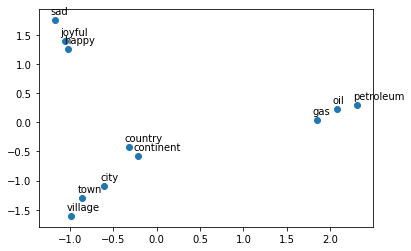

In [18]:
import matplotlib.pyplot as plt # Import matplotlib

plt.scatter(reduced[:, 0], reduced[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 0] - 0.05, reduced[i, 1] + 0.1))

plt.show()

Do you notice it?  
The word vectors for 'gas', 'oil' and 'petroleum' appear **related to each other, because their vectors are close to each other**. Similarly the other clusters, e.g. 'sad', 'joyful' and 'happy' all express emotions and are also near each other.  
  
You can take advantage of this type of consistency encoding
to identify patterns. For example, if you had the word doctor and
you were to find the closest words
that are closest to it by computing
some kind of similarity, you might get the word doctors, nurse, cardiologist,
surgeon, etc.  
  
To calculate a smilarity function we would need to be able to calculate the distance between the word vectors.  
We start by plotting an arrow between each word and a common Origin (0,0):

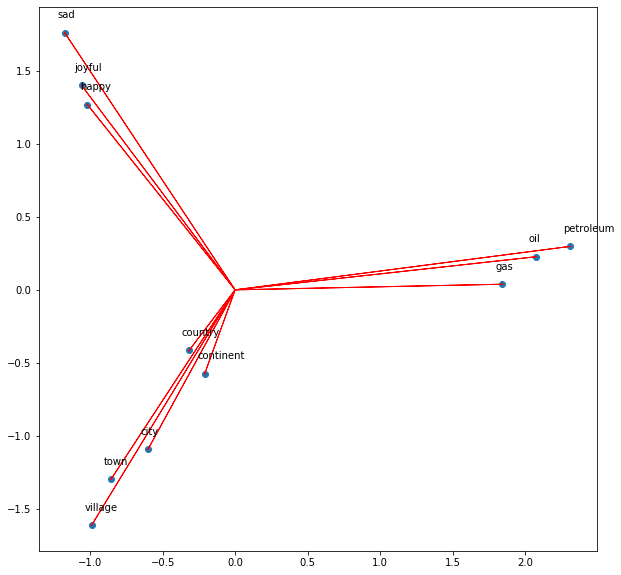

In [19]:
fig, ax = plt.subplots(figsize = (10, 10)) # Create custom size image

  # plot and annotate the words
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced[i, 0] - 0.05, reduced[i, 1] + 0.1))
    

# Print an arrow for each word starting from the Origin (0,0)
for word in range(0, len(words)):
    ax.arrow(0, 0, reduced[word,0], reduced[word,1], head_width=0.005, head_length=0.005, fc='r', ec='r', width = 1e-5)


plt.show()

When you perform a PCA reduction, you retain as much as possible information but something is always lost.  This is why you normally keep all dimensions for your model building and use PCA for visualisations or some reduction.  
  
Here is an example of another characteristic of word vectors that was not immediately visible in the previous plots which used a reduced-dimension data set.

In [20]:
  # a subset of words
words = ['happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'joyful']
embeddedWords = np.array([getVector(word) for word in words]) # Convert each word to its vector representation


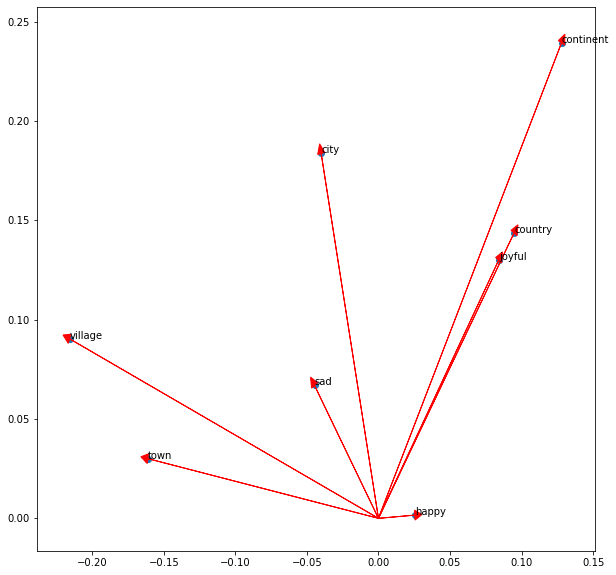

In [21]:
fig, ax = plt.subplots(figsize = (10, 10)) # Create custom size image

col1 = 3 # NOTE: we select a specific column (dimension) for the x axis
col2 = 2 # NOTE: and another specific column (one of the 300 dimensions) for the y axis

# Print an arrow for each word
for word in embeddedWords:
    ax.arrow(0, 0, word[col1], word[col2], head_width=0.005, head_length=0.005, fc='r', ec='r', width = 1e-5)

    
ax.scatter(embeddedWords[:, col1], embeddedWords[:, col2]); # Plot a dot for each word

# Add the word label over each dot in the scatter plot
for i in range(0, len(words)):
    ax.annotate(words[i], (embeddedWords[i, col1], embeddedWords[i, col2]))


plt.show()

The arrows are different since we have selected two specific dimensions and not the reduced PCA ones and words are more spread, not necessarily clustered together.    
But note that **similar words** like 'village' and 'town' or 'country' and 'continent' tend to **point in the same direction**.  
Also, note that **'sad' and 'happy' looks close to each other; however, the vectors point in opposite directions.**

In this chart, one can figure out the angles and distances between the words. Some words are close in both kinds of similarity metrics.

## Word distance

Now we will explore another peculiarity of the word vectors: how the distance between two vectors give an indication of the words similarity.  
We plot the words 'sad', 'happy', 'town', and 'village' as in the previous chart. In this same chart, display the vector from 'village' to 'town' and the vector from 'sad' to 'happy'.

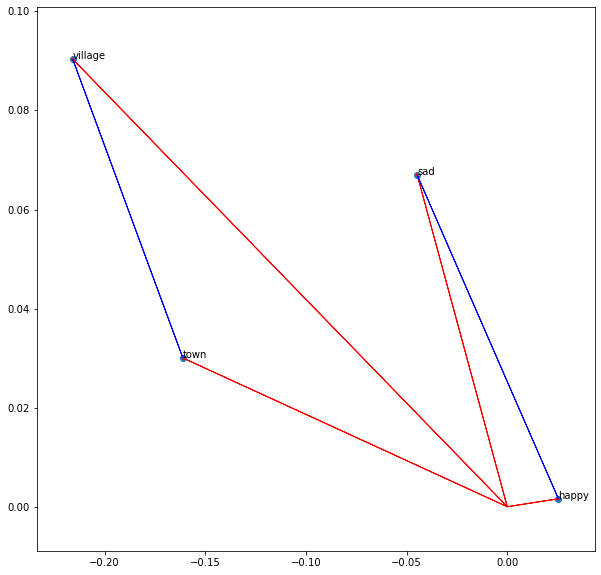

In [22]:
words = ['sad', 'happy', 'town', 'village']

embeddedWords = np.array([getVector(word) for word in words]) # Convert each word to its vector representation

fig, ax = plt.subplots(figsize = (10, 10)) # Create custom size image

col1 = 3 # Select the column for the x axe
col2 = 2 # Select the column for the y axe

# Print an arrow for each word
for word in embeddedWords:
    ax.arrow(0, 0, word[col1], word[col2], head_width=0.0005, head_length=0.0005, fc='r', ec='r', width = 1e-5)
    
# print the vector difference between village and town
village = getVector('village')
town = getVector('town')
diff = town - village
ax.arrow(village[col1], village[col2], diff[col1], diff[col2], fc='b', ec='b', width = 1e-5)

# print the vector difference between village and town
sad = getVector('sad')
happy = getVector('happy')
diff = happy - sad
ax.arrow(sad[col1], sad[col2], diff[col1], diff[col2], fc='b', ec='b', width = 1e-5)


ax.scatter(embeddedWords[:, col1], embeddedWords[:, col2]); # Plot a dot for each word

# Add the word label over each dot in the scatter plot
for i in range(0, len(words)):
    ax.annotate(words[i], (embeddedWords[i, col1], embeddedWords[i, col2]))


plt.show()



The distance between the words village and town is plotted in blue.  
Note that it has a similar length than the distance between happy and sad. This is a characteristic that can be useful for pattern recognition and predictions and we will  see how now.

## Predict relationships among words

Now we will write a function that will use the word embeddings (specifically the distance) to predict relationships among words!  
* The function will take as input three words.
* The first two are related to each other.
* It will predict a 4th word which is related to the third word in a similar manner as the two first words are related to each other.
* As an example, "Athens is to Greece as Bangkok is to ______"?

We will use the function to tell the capital of a country.
To do this, we will first compute the distance: the cosine similarity or the Euclidean distance.

### Predicting capitals

Now, applying vector difference and addition, one can create a vector representation for a new word. For example, we can say that the vector difference between 'France' and 'Paris' **represents the concept of Capital city**.

One can move from the city of Madrid in the direction of the concept of Capital, and obtain something close to the corresponding country to which Madrid is the Capital.  
How cool is that?

In [23]:
capital = getVector('France') - getVector('Paris')
country = getVector('Madrid') + capital

print(country[0:5]) # Print the first 5 values of the vector

[-0.02905273 -0.2475586   0.53952026  0.20581055 -0.14862823]


We can observe that the vector 'country' that we expected to be the same as the vector for Spain is not exactly it.

In [24]:
diff = country - getVector('Spain')
print(diff[0:5])

[-0.06054688 -0.06494141  0.37643433  0.08129883 -0.13007355]


So, we have to look for the **closest words** in the embedding that matches the candidate country. If the word embedding works as expected, the most similar word must be 'Spain'.  
Let us define a function that helps us to do it. We will store our word embedding as a DataFrame, which facilitate the lookup operations based on the numerical vectors.

The Euclidean similarity metric allows to identify how far two points or two vectors are apart from each other.
The Euclidean distance is the length of the straight line segment connecting two vector points in the vector space:  
$ d(A,B) = \sqrt{(b1-a1)^2 + (b2-a2)^2} $  
As you see, this formula is just from the Pythagorean theorem.
When you have higher dimensions, the Euclidean distance is not much more difficult: get the difference between each of their dimensions, square those differences, sum them up and then get the square root of the results.  
This formula is known as the norm of the difference between the vectors that you are comparing and in Python you can use the linalg module from numpy to get the norm of the difference, which works for n-dimensional spaces.  
By using this metric, you can get a sense of how similar two documents or words are.

In [25]:
def euclidean(A, B):
    """
    Input:
        A: a numpy array which corresponds to a word vector
        B: A numpy array which corresponds to a word vector
    Output:
        d: numerical number representing the Euclidean distance between A and B.
    """

    # euclidean distance

    return np.linalg.norm(A - B)

In [26]:
# feel free to try different words
king = getVector('king')
queen = getVector('queen')

# Test the function
euclidean(king, queen)

2.4796925

In [27]:
euclidean(getVector('Italy'), getVector('Rome'))

2.707084

In [28]:
# Create a dataframe out of the dictionary embedding. 
# NOTE: This facilitate the algebraic operations

keys = word_embeddings.keys()
lista = []
for key in keys:
    lista.append(word_embeddings[key])

embedding = pd.DataFrame(data=lista, index=keys)

In [29]:
# Define a function to find the closest word to a vector:
def find_closest_word(v):
      # Calculate the vector difference from each word to the input vector
    diff = embedding.values - v 
      # Get the norm of each difference vector. 
      # It means the squared euclidean distance from each word to the input vector
    delta = np.sum(diff * diff, axis=1)
      # Find the index of the minimun distance in the array
    i = np.argmin(delta)
      # Return the row name for this item
    return embedding.iloc[i].name



Now let us find the name that corresponds to our numerical country:

In [30]:
find_closest_word(country)

'Spain'

Yes, as expected!  
Now you have a simple process to get unknown relationships between words by the use of known relationships between others.  
The only catch here is that you need a vector space where the representations capture the relative meaning of words.  

In [31]:
find_closest_word(getVector('Italy') - getVector('Rome') + getVector('Madrid'))

'Spain'

Once we have a vector representing the "concept of Capital" (the difference between the vectors of a country and its capital city) we can directly search for the closest word, without calculating the capital vector each time.  
Now let's try with another combination:

In [32]:
# capital vector is coming from the first example: France and Paris
print(find_closest_word(getVector('Berlin') + capital))
print(find_closest_word(getVector('Beijing') + capital))

Germany
China


However, it does not always work:

In [33]:
print(find_closest_word(getVector('Lisbon') + capital))

Lisbon


We can improve this by using a different similarity metric than the Euclidean distance and that is the cosine distance.  

The cosine similarity function is one of the most
popular similarity functions.  
The cosine distance basically makes use of the cosine
of the angle between two vectors. And based off that, it tells 
whether two vectors are close or not.  
The cosine similarity also allows to overcome a problem when using euclidean distance:   comparing vector
representations of documents or corpora when they have different number of words will return biased results.

As said, the cosine similarity is computing the cosine
of the vectors' inner angle. If the angle is small,
the cosine would be close to one. And as the angle approaches 90 degrees,
the cosine approaches zero.  
In many cases, the cosine of those angles is a better
proxy of similarity between these vector representations than
their euclidean distance. 

In [34]:
def cosine_similarity(A, B):
    '''
    Input:
        A: a numpy array which corresponds to a word vector
        B: another numpy array which corresponds to a second word vector
    Output:
        cosine: numerical number representing the cosine similarity between A and B.
    '''
      # The dot product between two vectors is the sum of the products between their elements in each dimension of the vector space. 
    dot = np.dot(A,B)
      # The norm of a vector or its magnitude is defined to be the square root of the sum of its elements squared.
    norma = np.sqrt(np.dot(A,A))
    normb = np.sqrt(np.dot(B,B))
      #the cosine of the angle is equal to the dot product between the vectors divided by the product of the two norms. 
    cosine = dot / (norma*normb)

    return cosine

In [35]:
# feel free to try different words
king = word_embeddings['king']
queen = word_embeddings['queen']

cosine_similarity(king, queen)

0.6510957

In [36]:
village = word_embeddings['village']

cosine_similarity(king, village)

0.111293636

Remember that if the angle is small,
the cosine would be close to one and that means the two words are more similar. And as the angle approaches 90 degrees,
the cosine approaches zero and the words are less similar.

### Finding the country of each capital

Now, we  will use the cosine distance to find the capital cities of countries, in a similar way as previously, putting all together in one handy function:

In [37]:
def get_country(city1, country1, city2, embeddings):
    """
    Input:
        city1: a string (the capital city of country1)
        country1: a string (the country of capital1)
        city2: a string (another capital city of unknown country)
        embeddings: a dictionary where the keys are words and values are their embeddings
    Output:
        country: tuple, the most likely country and its similarity score
    """

    # store the city1, country 1, and city 2 in a set called group
    group = set((city1, country1, city2))

    # get embeddings of city 1
    city1Emb = word_embeddings[city1]

    # get embedding of country 1
    country1Emb =  word_embeddings[country1]

    # get embedding of city 2
    city2Emb = word_embeddings[city2]

    # get embedding of country 2 (it's a combination of the embeddings of country 1, city 1 and city 2)
    # Remember: King - Man + Woman = Queen
    connectingVector = country1Emb - city1Emb + city2Emb

    # Initialize the similarity to -1 (it will be replaced by a similarities that are closer to +1)
    bestSimilarity = -1

    # initialize country to an empty string
    country = ''

    # loop through all words in the embeddings dictionary
    for word in embeddings.keys():

        # first check that the word is not already in the 'group'
        if word not in group:

            # get the word embedding
            wordEmb = word_embeddings[word]

            # calculate cosine similarity between embedding of country 2 and the word in the embeddings dictionary
            currentSimilarity = cosine_similarity(connectingVector, wordEmb)

            if currentSimilarity > bestSimilarity:

                bestSimilarity = currentSimilarity

                # store the country as a tuple, which contains the word and the similarity
                country = (word, bestSimilarity)

    return country

In [38]:
# Testing the function, note to make it more robust you can return the 5 most similar words.
get_country('Athens', 'Greece', 'Cairo', word_embeddings)

('Egypt', 0.7626821)

In [39]:
get_country('Rome', 'Italy', 'Madrid', word_embeddings)


('Spain', 0.7485605)

In [40]:
get_country('Rome', 'Italy', 'Berlin', word_embeddings)

('Germany', 0.7864466)

In [41]:
get_country('Rome', 'Italy', 'Beijing', word_embeddings)

('China', 0.74696225)

In [42]:
get_country('Rome', 'Italy', 'Lisbon', word_embeddings)

('Portugal', 0.6622135)

And this time it predicted correctly that Lisbon is the capital city of Portugal!

## Model Accuracy

Now we will test the new function on the dataset and check the accuracy of the model:

$$\text{Accuracy}=\frac{\text{Correct # of predictions}}{\text{Total # of predictions}}$$

In [43]:
def get_accuracy(word_embeddings, data):
    '''
    Input:
        word_embeddings: a dictionary where the key is a word and the value is its embedding
        data: a pandas dataframe containing all the country and capital city pairs
    
    Output:
        accuracy: the accuracy of the model
    '''

    num_correct = 0

    # loop through the rows of the dataframe
    for i, row in data.iterrows():

        city1 = row['city1']
        country1 = row['country1']

        city2 =  row['city2']
        country2 = row['country2']

        # use get_country to find the predicted country2
        predicted_country2, _ = get_country(city1, country1, city2, word_embeddings)

        # if the predicted country2 is the same as the actual country2...
        if predicted_country2 == country2:
            # increment the number of correct predictions by 1
            num_correct += 1

    m = len(data)

    # calculate the accuracy by dividing the number of correct predictions by 
    # the number of rows in the data dataframe (length of dataframe)
    accuracy = num_correct / m

    return accuracy

In [44]:
accuracy = get_accuracy(word_embeddings, data)
print(f"Accuracy is {accuracy:.2f}")

Accuracy is 0.92


The function could predict the correct country 92% of the times, which is quite good.  
I doubt that I could do better.